Initial setup, imports

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import gymnasium as gym
import random
from queue import Queue

In [3]:
#create a basic grid map
map = tf.zeros([16, 16], tf.int32)


In [4]:
column_indexes = [0, 15]
row_indexes = [0, 15]

column_indices=[]
row_indices=[]

for idx in column_indexes:
    column_indices.extend([[i, idx] for i in range(16)])
for idx in row_indexes:
    row_indices.extend([[idx, i] for i in range(16)])

# Combine row and column indices
indices = tf.constant(column_indices + row_indices, dtype=tf.int32)
print(indices)
# Create the corresponding updates
updates = tf.ones((len(indices),), dtype=tf.int32)
print(updates)
map = tf.tensor_scatter_nd_update(
    map,
    indices = indices,
    updates = updates
)

print(map)

tf.Tensor(
[[ 0  0]
 [ 1  0]
 [ 2  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 6  0]
 [ 7  0]
 [ 8  0]
 [ 9  0]
 [10  0]
 [11  0]
 [12  0]
 [13  0]
 [14  0]
 [15  0]
 [ 0 15]
 [ 1 15]
 [ 2 15]
 [ 3 15]
 [ 4 15]
 [ 5 15]
 [ 6 15]
 [ 7 15]
 [ 8 15]
 [ 9 15]
 [10 15]
 [11 15]
 [12 15]
 [13 15]
 [14 15]
 [15 15]
 [ 0  0]
 [ 0  1]
 [ 0  2]
 [ 0  3]
 [ 0  4]
 [ 0  5]
 [ 0  6]
 [ 0  7]
 [ 0  8]
 [ 0  9]
 [ 0 10]
 [ 0 11]
 [ 0 12]
 [ 0 13]
 [ 0 14]
 [ 0 15]
 [15  0]
 [15  1]
 [15  2]
 [15  3]
 [15  4]
 [15  5]
 [15  6]
 [15  7]
 [15  8]
 [15  9]
 [15 10]
 [15 11]
 [15 12]
 [15 13]
 [15 14]
 [15 15]], shape=(64, 2), dtype=int32)
tf.Tensor(
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(64,), dtype=int32)
tf.Tensor(
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 

In [5]:
npmap = np.zeros((16, 16), np.int8)
idxs = [0, 15]
for i in idxs:
    npmap[i, :] = 1
    npmap[:, i] = 1



In [6]:
class Node: #nodes feature coordinate system, wall boolean and neighbour list
    def __init__(self, row, col):
        self.row = row
        self.col = col
        self.neighbours=[]
        self.is_wall = True
        self.is_hazard = False

class Map: #map containing grid of nodes, square based on map_size
    def __init__(self, map_size):
        self.grid = [[Node(row, col) for col in range(map_size)] for row in range(map_size)]
        self.size = map_size

class UnionFind: #unionFind algorithm for joining nodes
    def __init__(self, map):
        self.parent=[[(r, c) for c in range(map.size)] for r in range(map.size)] #parents are coordinates as id
        self.rank=[[0 for c in range(map.size)] for r in range(map.size)] #rank for union by rank
        
    def find(self, coord): #check parent of cnode by coordinate
        r, c = coord
        if self.parent[r][c] != coord: #if parent is not itself
            self.parent[r][c] = self.find(self.parent[r][c]) #find actual parent
        return self.parent[r][c] #return parent
    
    def union(self, coord1, coord2): #join two nodes
        #print("UNION: coord1:", coord1, "coord2:", coord2)
        root1 = self.find(coord1) #get parent of coord1
        root2 = self.find(coord2) #get parent of coord2

        #print("UNION: root1:", root1, "root2:", root2)
        if root1 != root2: #
            r1, c1 = root1
            r2, c2 = root2
            #print("RANKS: rank1 =", self.rank[r1][c1], ", rank2 =", self.rank[r2][c2])
            
            if self.rank[r1][c1] > self.rank[r2][c2]:
                self.parent[r2][c2] = root1
            elif self.rank[r1][c1] < self.rank[r2][c2]:
                self.parent[r1][c1] = root2
            else:
                self.parent[r2][c2] = root1
                self.rank[r1][c1] += 1

def createBareMap(size):
    map = Map(size)
    #iterate through map rows and cols
    for row in range(map.size):
        for col in range(map.size):
            node = map.grid[row][col]
            if row > 0:
                node.neighbours.append(map.grid[row - 1][col]) #north neighbour
            if row < map.size - 1:
                node.neighbours.append(map.grid[row + 1][col])  #south neighbour
            if col > 0:
                node.neighbours.append(map.grid[row][col - 1])  #west neighbour
            if col < map.size - 1:
                node.neighbours.append(map.grid[row][col + 1])  #east neighbour

    #set initial path cells
    for row in range(map.size):
        for col in range(map.size):
            if row % 2 == 1 and col % 2 == 1:
                map.grid[row][col].is_wall = False
    return map

def drawMap(map):
    for row in range(map.size):
            print(''.join(' ' if not node.is_wall else ('X' if node.is_hazard else '#') for node in map.grid[row]))

def getEdges(map): #if first pass get every 2nd wall, allowing for perfect maze
    edges=[]
    for row in range(1, map.size, 2): #start at 1, step by two to only get path cells
        for col in range(1, map.size, 2):
            if row + 2 < map.size:  #vert wall
                wall = map.grid[row + 1][col]
                cell1 = map.grid[row][col]
                cell2 = map.grid[row + 2][col]
                edges.append((wall, cell1, cell2))  # (wall, cell1, cell2)
            if col + 2 < map.size:  #horizontal wall
                wall = map.grid[row][col + 1]
                cell1 = map.grid[row][col]
                cell2 = map.grid[row][col + 2]
                edges.append((wall, cell1, cell2))
    return edges

def getRemainingWalls(map):
    walls=[]
    for row in range(1, map.size - 1): 
            for col in range(1, map.size - 1):
                if map.grid[row][col].is_wall and map.grid[row][col].is_hazard == False: #avoid hazards
                    walls.append(map.grid[row][col]) #append wall
    return walls

def getRemainingPaths(map):
    paths=[]
    for row in range(1, map.size - 1): 
            for col in range(1, map.size - 1):
                if not map.grid[row][col].is_wall: #avoid walls and hazard walls
                    paths.append(map.grid[row][col])  #append path
    return paths
        
def removeWalls(uf, edges): #takes a unionfind and edge list
    for wall, cell1, cell2 in edges:
        coord1 = (cell1.row, cell1.col)
        coord2 = (cell2.row, cell2.col)
        if uf.find(coord1) != uf.find(coord2):
            uf.union(coord1, coord2)
            wall.is_wall = False

def isBoundary(node, map):
    if node.row == 0:
        return True
    elif node.row == map.size - 1:
        return True
    elif node.col == 0:
        return True
    elif node.col == map.size - 1:
        return True
    else:
        return False

#todo could add max dist/max_amount for distance based removal
def createCycles(cycle_bias, cluster_strength, cluster_type, map, sigmoid_slope, distance_type="sigmoid"):
    num_edges = 0
    remaining_walls = getRemainingWalls(map)
    num_cycles = np.floor(cycle_bias * len(remaining_walls))

    print("Cycle bias, num edges, num cycles: ", (cycle_bias, num_edges, num_cycles))

    random.shuffle(remaining_walls)
    print("map before cycles")
    drawMap(map)
    counter = 0

    for wall in remaining_walls: #get a wall and remove it
        if counter < num_cycles:
            wall.is_wall = False
            counter += 1

            match cluster_type: #cluster removal of walls based on input, centred on removed wall
                case "pocket":
                    nearest=[]
                    for row in range(wall.row - 2, wall.row + 3):
                        for col in range(wall.col - 2, wall.col + 3):
                            if row < map.size and row > 0 and col < map.size and col > 0:                            
                                if map.grid[row][col].is_wall and not isBoundary(map.grid[row][col], map) and map.grid[row][col].is_hazard == False:
                                    nearest.append(map.grid[row][col])
                    for close_wall in nearest:
                        if random.random() < cluster_strength:
                            close_wall.is_wall = False
                            counter += 1

                case "distance": #flood fill search across map for walls
                    visited = {(wall.row, wall.col)}
                    #todo maybe make a list of queued? maybe not necessary
                    q = Queue()
                    for neighbour in wall.neighbours:
                        q.put(neighbour)

                    #iterate through neighbours and add new neighbours
                    while q.empty() != True and counter < num_cycles:
                        next = q.get() #get next node from neighbours
                        if next in visited:
                            continue
                        for next_neighbour in next.neighbours: #add new neighbours if not visted before
                            if (next_neighbour.row, next_neighbour.col) not in visited and not isBoundary(next_neighbour, map):
                                q.put(next_neighbour) #add node's neighbours to queue

                        if next.is_wall == True and not isBoundary(next, map) and next.is_hazard == False: #if current node is a wall, get coords
                            x1, y1 = wall.row, wall.col
                            x2, y2 = next.row, next.col
                            dist = abs(x1 - x2) + abs(y1 - y2)
                            match distance_type:
                                case "manhattan":
                                     if random.random() < (cluster_strength / dist): #manhattan distance reduction of removal chance
                                        next.is_wall = False #remove wall if chance succeeds
                                        counter += 1

                                case _: #sigmoid distance
                                     #manhattan distance with inverse sigmoid function
                                     if random.random() < (cluster_strength / (1 + np.exp(sigmoid_slope * (dist - map.size / 2)))): 
                                        next.is_wall = False #remove wall if chance succeeds
                                        counter += 1

                        visited.add((next.row, next.col)) #add the node we've just been through to visited set          

                case _:
                    #no clustering needed by default
                    continue
        else:
            break
    
    print("map after cycles")
    drawMap(map)

#function to randomly select some walls to turn to hazards
def addHazards(map, hazardLevel):
    remaining_walls = getRemainingWalls(map)
    random.shuffle(remaining_walls)

    for i in range(0, hazardLevel):
        remaining_walls[i].is_hazard = True

#in progress todo
#def addEntities(map, enemyLevel, entityOptions):
    #remaining_paths = getRemainingPaths(map)
    #random.shuffle(remaining_paths)

    #for i in range(0, 3): #minor objectives
    #create classes?
    #lists attached to map?
    #attach to tile?





In [13]:
def createCycleMap(size, cycle_bias, cluster_strength, cluster_type, sigmoid_slope=1, 
                   seed=-1, hazardLevel = 0, distance_type="sigmoid"):
    #init the map with size
    map = createBareMap(size)
    print("map before mazing")
    drawMap(map)
    #creating list of edges for kruskal
    edges = getEdges(map)
    #shuffle edges
    if seed != -1:
        random.seed(seed)    
    random.shuffle(edges)
    uf = UnionFind(map)  #start unionfind with a map
    removeWalls(uf, edges) #creates perfect maze
    addHazards(map, hazardLevel) #add hazards via remaining walls, ensuring level viability
    #creates non perfect maze
    createCycles(cycle_bias, cluster_strength, cluster_type, map, sigmoid_slope, distance_type) 
    return map

def getOpenTiles(map):
    maxOpenTiles = (map.size - 4) * (map.size - 4)
    openTileCount = 0
    for row in range(map.size):
        for col in range(map.size):
            tile = map.grid[row][col]
            if tile.is_wall == False and all(neighbour.is_wall == False for neighbour in tile.neighbours):
                openTileCount += 1
    return (openTileCount, (openTileCount / maxOpenTiles))
                
                
                

In [15]:
map = createCycleMap(15, 0.5, 1, "distance", seed=80, hazardLevel=5)
print(getOpenTiles(map))



map before mazing
###############
# # # # # # # #
###############
# # # # # # # #
###############
# # # # # # # #
###############
# # # # # # # #
###############
# # # # # # # #
###############
# # # # # # # #
###############
# # # # # # # #
###############
Cycle bias, num edges, num cycles:  (0.5, 0, 33.0)
map before cycles
###############
# # #         #
# # # ### ### #
# # # #   #   #
# X ### ##### #
#           # #
# ##### ### # #
# # #   #   # #
# # # # X######
# #   # #   X #
# # # # # X## #
# # # # #     #
### ### #X### #
#   #         #
###############
map after cycles
###############
# # #         #
# #       ### #
# #       #   #
# X        ## #
#           # #
#           # #
#           # #
# #     X #####
# #         X #
# #       X## #
# # #   #     #
### ##  #X### #
#   #         #
###############
(50, 0.4132231404958678)


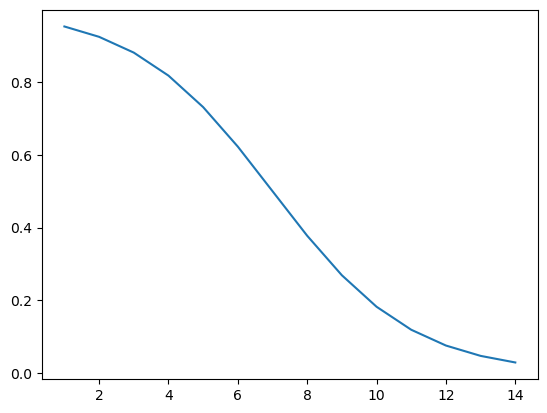

In [9]:
import matplotlib.pyplot as plt

#distances up to map.size
distances = np.arange(1, 15)
sigmoid_slope = 0.5

def sigmoid(distances, max):
    result = 1 /(1 + np.exp(sigmoid_slope * (distances - (max / 2)))) #inverse sigmoid with slope coefficient
    return result

max = np.max(distances)
y = sigmoid(distances, max)

fig, ax = plt.subplots()
ax.plot(distances, y)
